In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

In [2]:
pwd

'/Users/andrewstephens/Final_project/Modeling'

In [3]:
cd ..

/Users/andrewstephens/Final_project


In [4]:
df = pd.read_csv('Data/Preprocessing.csv',index_col=0)
df.head()

,age,campaign,pdays,previous,cons.price.idx,cons.conf.idx,nr.employed,y,job_admin.,job_blue-collar,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,93.994,-36.4,5191.0,no,1,0,...,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,93.994,-36.4,5191.0,no,0,0,...,0,1,0,0,0,0,1,0,1,0


In [5]:
X=df.drop(['y',"y_yes","y_no"], axis=1)
y=df['y']



# Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [7]:
X_train.shape, y_train.shape 

((28831, 60), (28831,))

# Making Sure Data is Balanced 



In [8]:
# summarize class distribution
print("Before undersampling: ", Counter(y_train))

# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train, y_train = undersample.fit_resample(X_train, y_train)

# summarize class distribution
print("After undersampling: ", Counter(y_train))

Before undersampling:  Counter({'no': 25580, 'yes': 3251})
After undersampling:  Counter({'no': 3251, 'yes': 3251})


In [ ]:
# Looks like our data is balanced

# Model Creation

We will be starting with KNN, a unsupervised learning method, because its versatile, simple, accurate and non assumpitve. Choosing K parameter will be most important, as it may cause overfitting if we are not careful. 

In [9]:
# pipeline combining transformers and estimator
pipe_knn= make_pipeline(StandardScaler(), KNeighborsClassifier())

In [10]:
# grid searh to choose the best (combination of) hyperparameters
gs_knn=GridSearchCV(estimator= pipe_knn,
               param_grid={'kneighborsclassifier__n_neighbors':[4,5,6,7]},
               scoring='accuracy',
               cv=4)


In [11]:



# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_knn_scores = cross_val_score(gs_knn, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)



In [12]:
# fit, and fit with best estimator
gs_knn.fit(X_train, y_train)
gs_knn_best=gs_knn.best_estimator_
gs_knn_best.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])

In [13]:
print('Train Accuracy:   {0:.1f}%'.format(gs_knn.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_knn.score(X_test, y_test)*100))


Train Accuracy:   76.0%
Test Accuracy:    74.8%


In [14]:
#confusion_matrix and classification report
ypreds=gs_knn_best.predict(X_test)
print(confusion_matrix(ypreds ,y_test))
print(classification_report(ypreds ,y_test))



[[8380  524]
 [2588  865]]
              precision    recall  f1-score   support

          no       0.76      0.94      0.84      8904
         yes       0.62      0.25      0.36      3453

    accuracy                           0.75     12357
   macro avg       0.69      0.60      0.60     12357
weighted avg       0.72      0.75      0.71     12357



In [15]:
#confusion matrix 

Confusion matrix, without normalization
[[8380 2588]
 [ 524  865]]
Normalized confusion matrix
[[0.76404085 0.23595915]
 [0.37724982 0.62275018]]


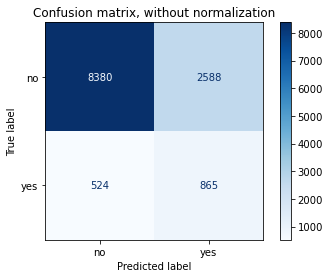

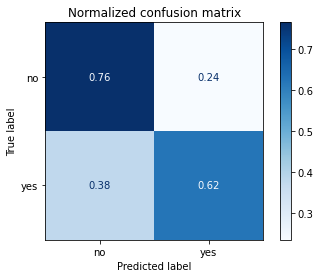

In [16]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_knn, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


Looks really good ! Now lets try SVM 

# SVM 

A support vector machine is a machine learning model that is able to generalise between two different classes if the set of labelled data is provided in the training set to the algorithm. The main function of the SVM is to check for that hyperplane that is able to distinguish between the two classes.[1]

In [17]:
# pipeline combining transformers and estimator
pipe_svm= make_pipeline(StandardScaler(), SVC(random_state=1))

# grid searh to choose the best (combination of) hyperparameters
r=[0.1,1,10]
pg_svm=[ {'svc__C':r, 'svc__gamma':r, 'svc__kernel':['rbf']}]

gs_svm=GridSearchCV(estimator= pipe_svm,
               param_grid= pg_svm,
               scoring='accuracy',
               cv=4)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_svm_scores = cross_val_score(gs_svm, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_svm.fit(X_train, y_train)
gs_svm_best=gs_svm.best_estimator_
gs_svm_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_svm.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_svm.score(X_test, y_test)*100))

Train Accuracy:   93.0%
Test Accuracy:    67.7%


In [18]:
#confusion_matrix and classification report
ypreds=gs_svm_best.predict(X_test)
print(confusion_matrix(ypreds ,y_test))
print(classification_report(ypreds ,y_test))



[[7398  421]
 [3570  968]]
              precision    recall  f1-score   support

          no       0.67      0.95      0.79      7819
         yes       0.70      0.21      0.33      4538

    accuracy                           0.68     12357
   macro avg       0.69      0.58      0.56     12357
weighted avg       0.68      0.68      0.62     12357



Confusion matrix, without normalization
[[7398 3570]
 [ 421  968]]
Normalized confusion matrix
[[0.67450766 0.32549234]
 [0.30309575 0.69690425]]


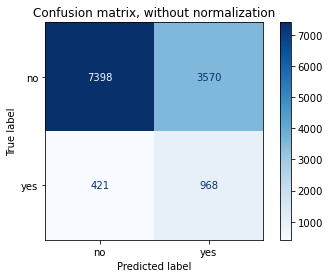

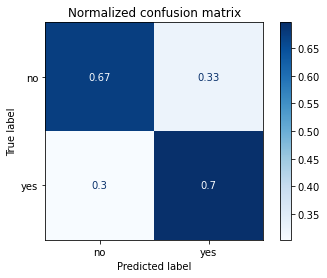

In [19]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_svm, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


# Random Forest

In [20]:
rf= RandomForestClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_rf={'n_estimators': [100,200,400],'max_depth': [20,40,50,60]}

gs_rf=GridSearchCV(estimator= rf,
               param_grid= pg_rf,
               scoring='accuracy',
               cv=4)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_rf_scores = cross_val_score(gs_rf, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_rf.fit(X_train, y_train)
gs_rf_best=gs_rf.best_estimator_
gs_rf_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_rf.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_rf.score(X_test, y_test)*100))

Train Accuracy:   97.2%
Test Accuracy:    80.5%


In [21]:
#confusion_matrix and classification report
ypreds=gs_rf_best.predict(X_test)
print(confusion_matrix(ypreds ,y_test))
print(classification_report(ypreds ,y_test))



[[9073  512]
 [1895  877]]
              precision    recall  f1-score   support

          no       0.83      0.95      0.88      9585
         yes       0.63      0.32      0.42      2772

    accuracy                           0.81     12357
   macro avg       0.73      0.63      0.65     12357
weighted avg       0.78      0.81      0.78     12357



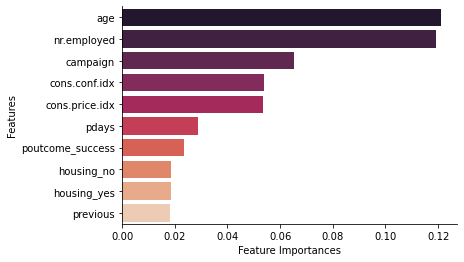

In [22]:
# using random forest to get feature importances
importances= gs_rf_best.feature_importances_
feature_importances= pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10], palette="rocket")
sns.despine()
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

Confusion matrix, without normalization
[[9073 1895]
 [ 512  877]]
Normalized confusion matrix
[[0.82722465 0.17277535]
 [0.36861051 0.63138949]]


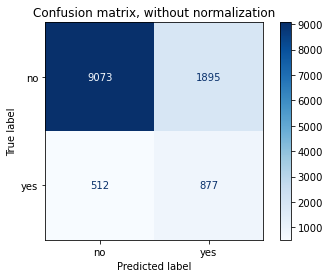

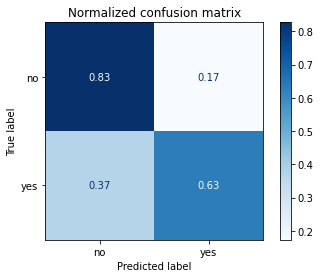

In [23]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_rf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


Age seems to be the biggest factor,but that is no surprise because the younger they can get a client, the longer they can do business with them over the course of their life.Volume is another factor, because we can see how important the number of employees to carry through the campaign is.That means to say that any decrease in the workforce would have negative effects to the marketing campaign. 

# Gradient Boosting 


In [24]:
# estimator
xb= xgb.XGBClassifier(random_state=1)

# grid searh to choose the best (combination of) hyperparameters
pg_xb={'n_estimators':[100,200,400], 'max_depth':[20,40,50]}

gs_xb=GridSearchCV(estimator= xb,
               param_grid= pg_xb,
               scoring='accuracy',
               cv=4)

# nested cross validation combining grid search (inner loop) and k-fold cv (outter loop)
gs_xb_scores = cross_val_score(gs_xb, X=X_train, y=y_train, cv=5,scoring='accuracy', n_jobs=-1)

# fit, and fit with best estimator
gs_xb.fit(X_train, y_train)
gs_xb_best=gs_xb.best_estimator_
gs_xb_best.fit(X_train, y_train)

print('Train Accuracy:   {0:.1f}%'.format(gs_xb.score(X_train, y_train)*100))
print('Test Accuracy:    {0:.1f}%'.format(gs_xb.score(X_test, y_test)*100))


Train Accuracy:   99.5%
Test Accuracy:    72.4%


In [25]:
# using random forest results: confusion_matrix and classification report
ypreds=gs_xb_best.predict(X_test)
print(confusion_matrix(ypreds ,y_test))
print(classification_report(ypreds ,y_test))


[[8034  479]
 [2934  910]]
              precision    recall  f1-score   support

          no       0.73      0.94      0.82      8513
         yes       0.66      0.24      0.35      3844

    accuracy                           0.72     12357
   macro avg       0.69      0.59      0.59     12357
weighted avg       0.71      0.72      0.68     12357



Confusion matrix, without normalization
[[8034 2934]
 [ 479  910]]
Normalized confusion matrix
[[0.73249453 0.26750547]
 [0.34485241 0.65514759]]


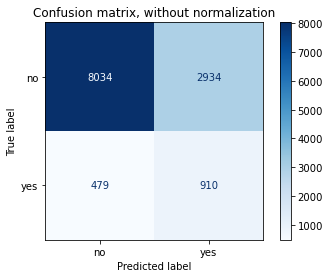

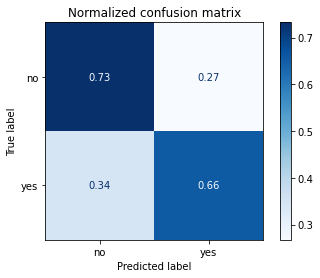

In [26]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(gs_xb, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Reference #1  https://www.analyticssteps.com/blogs/how-does-support-vector-machine-algorithm-works-machine-learning 

https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/